# Dst & SYM-H Prediction from 3DCORE output

In [1]:
# Conda dependencies are listed under environment.yml
import os
import sys
import copy
from datetime import datetime, timedelta
import getpass
import logging
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import num2date, date2num
import numpy as np
import pdb
import pickle
import requests
import scipy.io
from scipy import stats
import scipy
import warnings
from sunpy.time import parse_time
import sklearn
import pandas as pd
import matplotlib.dates as mdates
import astropy.units as u
from scipy.optimize import curve_fit, least_squares, minimize
import time
import numba
from numba import jit
from astropy.time import Time, TimeDelta
from sunpy.coordinates import HeliographicStonyhurst, HeliocentricEarthEcliptic
import astrospice
#from heliocats import data as hd
from functions.data import SatData
from functions.data import PositionData
import urllib
import multiprocess as mp

import seaborn as sns
from sklearn.metrics import mean_squared_error
#from heliocats import plot as hp

#import heliosat
#import functions as ps
from functions import data as pred
#from predstorm.config.conscnts import AU, dist_to_L1
#from predstorm.predict import dst_loss_function

warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings

sns.set_style('whitegrid')
sns.set_context('paper')

#data_path = '/data/aswo/data/insitu_python/'

### DATA READING 

In [63]:
#file = open('data_3DCORE/3dcore_dscovr_2024Oct10_fromlasttfit.pickle', 'rb')
#file = open('data_3DCORE/3dcore_dscovr_2024Oct10_fromlasttfit_3.pickle', 'rb')

file_fr = open('data_3DCORE/95min/3dcore_dscovr_2022Jul07_fluxrope.pickle', 'rb')
time_dst, btt_dst, bxx_dst, byy_dst, bzz_dst, denss_dst, vell_dst = pickle.load(file_fr)

file_err = open('data_3DCORE/95min/3dcore_dscovr_2022Jul07_ensemble.pickle', 'rb')
time_sig, bt0_sig, bt1_sig, bx0_sig, bx1_sig, by0_sig, by1_sig, bz0_sig, bz1_sig, dens_sig, vel_sig = pickle.load(file_err)

file_err2 = open('data_3DCORE/95min/3dcore_dscovr_2022Jul07_ensemble_2sig.pickle', 'rb')
time_2sig, bt0_2sig, bt1_2sig, bx0_2sig, bx1_2sig, by0_2sig, by1_2sig, bz0_2sig, bz1_2sig, dens_2sig, vel_2sig = pickle.load(file_err2)

year = time_dst[0].year

In [20]:
[olr, olr_header] = pickle.load(open('data_3DCORE/omni_1963_now.p', 'rb'))
[ohr, ohr_header] = pickle.load(open('data_3DCORE/omni_high_res_'+str(year)+'.p', 'rb'))

olr_cut_lower = np.where(olr.time >= time_sig[0])[0][0]
olr_cut_upper = np.where(olr.time >= time_sig[-1]+timedelta(hours=12))[0][0]

ohr_cut_lower = np.where(ohr.time >= time_sig[0])[0][0]
ohr_cut_upper = np.where(ohr.time >= time_sig[-1]+timedelta(hours=12))[0][0]

olr = olr[olr_cut_lower:olr_cut_upper]
ohr = ohr[ohr_cut_lower:ohr_cut_upper]

#print(olr.time)

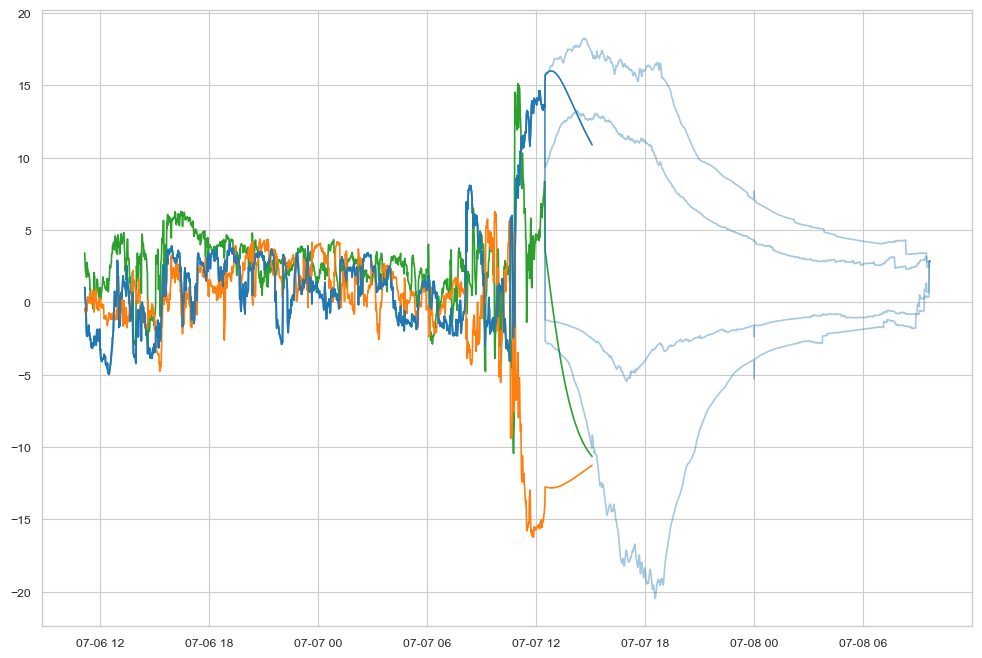

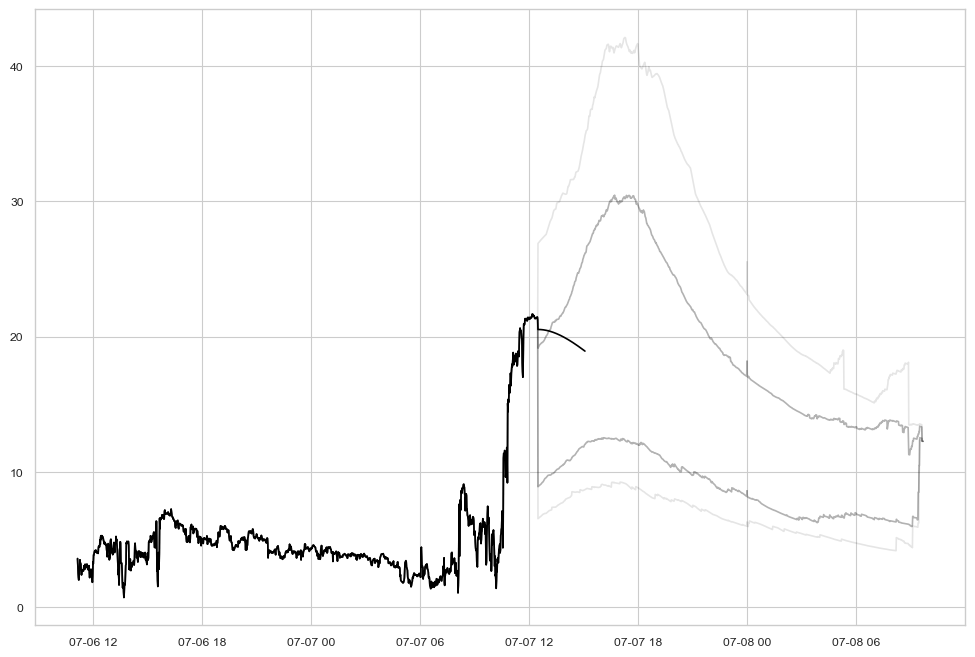

In [21]:
plt.figure(1, figsize=(12,8))
plt.plot(time_dst, bxx_dst, c='tab:blue')
plt.plot(time_dst, byy_dst, c='tab:green')
plt.plot(time_dst, bzz_dst, c='tab:orange')

plt.plot(time_sig, bx1_sig, alpha=0.4, c='tab:blue')
#plt.plot(time_sig, by1_sig, alpha=0.4, c='tab:green')
#plt.plot(time_sig, bz1_sig, alpha=0.4, c='tab:orange')
plt.plot(time_sig, bx0_sig, alpha=0.4, c='tab:blue')
#plt.plot(time_sig, by0_sig, alpha=0.4, c='tab:green')
#plt.plot(time_sig, bz0_sig, alpha=0.4, c='tab:orange')

plt.plot(time_2sig, bx1_2sig, alpha=0.4, c='tab:blue')
#plt.plot(time_2sig, by1_2sig, alpha=0.4, c='tab:green')
#plt.plot(time_2sig, bz1_2sig, alpha=0.4, c='tab:orange')
plt.plot(time_2sig, bx0_2sig, alpha=0.4, c='tab:blue')
#plt.plot(time_2sig, by0_2sig, alpha=0.4, c='tab:green')
#plt.plot(time_2sig, bz0_2sig, alpha=0.4, c='tab:orange')

plt.figure(2, figsize=(12,8))
plt.plot(time_dst, btt_dst, c='k')
plt.plot(time_sig, bt0_sig, c='k', alpha=0.3)
plt.plot(time_sig, bt1_sig, c='k', alpha=0.3)
plt.plot(time_2sig, bt0_2sig, c='k', alpha=0.1)
plt.plot(time_2sig, bt1_2sig, c='k', alpha=0.1)


#plt.figure(2, figsize=(12,8))
#plt.plot(time_arr_new, vel_new)

#plt.figure(3, figsize=(12,8))
#plt.plot(time_arr_new, dens_new)

In [22]:
# make SatData oject for Dst-calculation

sc_fr = SatData({'time': mdates.date2num(time_dst),
               'btot': btt_dst, 
               'bx': bxx_dst,
               'by': byy_dst, 
               'bz': bzz_dst, 
               'speed': vell_dst, 'density': denss_dst}, source='3DCORE')

#Positions = PositionData([sc_input.r, np.deg2rad(sc_input.lon), np.deg2rad(sc_input.lat)], postype='rlonlat')#

#Positions.h['Units'] = 'AU'
#Positions.h['ReferenceFrame'] = 'HEEQ'
#Positions.h['Observer'] = 'Sun'
#sc_0.pos = Positions

sc_fr.interp_nans()

sc_fr.h['DataSource'] = "DSCOVR"
sc_fr.h['SamplingRate'] = mdates.num2date(sc_fr['time'][1]) - mdates.num2date(sc_fr['time'][0])
#sc_0.h['ReferenceFrame'] = "RTN"
#sc_0.h['Instruments'] = ['PLASTIC', 'IMPACT']
#sc_0.h['CoordinateSystem'] = 'rlonlat'
#sc_0.h['CoordinateSystem'] = 'xyz'

#sc_0.convert_RTN_to_GSE()
#sc_0.convert_GSE_to_GSM()

sc_fr_dst = sc_fr.make_hourly_data()

print(sc_fr)
print(sc_fr_dst)

Length of data:		1666
Keys in data:		['speed', 'density', 'bx', 'by', 'bz', 'btot']
First data point:	2022-07-06 11:09:00+00:00
Last data point:	2022-07-07 15:04:00+00:00

Header information:
                   DataSource:	DSCOVR
                    SourceURL:	
                 SamplingRate:	0:01:00
               ReferenceFrame:	
                  FileVersion:	{}
                  Instruments:	[]
                 RemovedTimes:	[]
          PlasmaDataIntegrity:	10

Variable statistics:
         VAR        MEAN         STD
       speed      339.03       33.90
     density       17.72        9.24
          bx        2.56        5.04
          by        1.97        3.57
          bz       -1.14        5.23
        btot        6.66        5.74

Length of data:		28
Keys in data:		['speed', 'density', 'bx', 'by', 'bz', 'btot']
First data point:	2022-07-06 12:00:00+00:00
Last data point:	2022-07-07 15:00:00+00:00

Header information:
                   DataSource:	DSCOVR
                    S

In [23]:
# make SatData oject for Dst-calculation

sc_0 = SatData({'time': mdates.date2num(time_sig),
               'btot': bt0_sig, 
               'bx': bx0_sig,
               'by': by0_sig, 
               'bz': bz0_sig, 
               'speed': vel_sig, 'density': dens_sig}, source='3DCORE')

#Positions = PositionData([sc_input.r, np.deg2rad(sc_input.lon), np.deg2rad(sc_input.lat)], postype='rlonlat')#

#Positions.h['Units'] = 'AU'
#Positions.h['ReferenceFrame'] = 'HEEQ'
#Positions.h['Observer'] = 'Sun'
#sc_0.pos = Positions

sc_0.interp_nans()

sc_0.h['DataSource'] = "DSCOVR"
sc_0.h['SamplingRate'] = mdates.num2date(sc_0['time'][1]) - mdates.num2date(sc_0['time'][0])
#sc_0.h['ReferenceFrame'] = "RTN"
#sc_0.h['Instruments'] = ['PLASTIC', 'IMPACT']
#sc_0.h['CoordinateSystem'] = 'rlonlat'
#sc_0.h['CoordinateSystem'] = 'xyz'

#sc_0.convert_RTN_to_GSE()
#sc_0.convert_GSE_to_GSM()

sc_0_dst = sc_0.make_hourly_data()

print(sc_0)
print(sc_0_dst)

# make SatData oject for Dst-calculation

sc_0_2sig = SatData({'time': mdates.date2num(time_2sig),
               'btot': bt0_2sig, 
               'bx': bx0_2sig,
               'by': by0_2sig, 
               'bz': bz0_2sig, 
               'speed': vel_2sig, 'density': dens_2sig}, source='3DCORE')

#Positions = PositionData([sc_input.r, np.deg2rad(sc_input.lon), np.deg2rad(sc_input.lat)], postype='rlonlat')#

#Positions.h['Units'] = 'AU'
#Positions.h['ReferenceFrame'] = 'HEEQ'
#Positions.h['Observer'] = 'Sun'
#sc_0.pos = Positions

sc_0_2sig.interp_nans()

sc_0_2sig.h['DataSource'] = "DSCOVR"
sc_0_2sig.h['SamplingRate'] = mdates.num2date(sc_0_2sig['time'][1]) - mdates.num2date(sc_0_2sig['time'][0])
#sc_0.h['ReferenceFrame'] = "RTN"
#sc_0.h['Instruments'] = ['PLASTIC', 'IMPACT']
#sc_0.h['CoordinateSystem'] = 'rlonlat'
#sc_0.h['CoordinateSystem'] = 'xyz'

#sc_0.convert_RTN_to_GSE()
#sc_0.convert_GSE_to_GSM()

sc_0_2sig_dst = sc_0_2sig.make_hourly_data()

print(sc_0_2sig)
print(sc_0_2sig_dst)

Length of data:		2778
Keys in data:		['speed', 'density', 'bx', 'by', 'bz', 'btot']
First data point:	2022-07-06 11:09:00+00:00
Last data point:	2022-07-08 09:40:00+00:00

Header information:
                   DataSource:	DSCOVR
                    SourceURL:	
                 SamplingRate:	0:01:00
               ReferenceFrame:	
                  FileVersion:	{}
                  Instruments:	[]
                 RemovedTimes:	[]
          PlasmaDataIntegrity:	10

Variable statistics:
         VAR        MEAN         STD
       speed      365.00       41.23
     density       19.89        7.63
          bx        3.67        4.48
          by        0.74        5.64
          bz        0.96        4.18
        btot       11.80        8.67

Length of data:		46
Keys in data:		['speed', 'density', 'bx', 'by', 'bz', 'btot']
First data point:	2022-07-06 12:00:00+00:00
Last data point:	2022-07-08 09:00:00+00:00

Header information:
                   DataSource:	DSCOVR
                    S

In [24]:
# make SatData oject for Dst-calculation

sc_1 = SatData({'time': mdates.date2num(time_sig),
               'btot': bt1_sig, 
               'bx': bx1_sig,
               'by': by1_sig, 
               'bz': bz1_sig, 
               'speed': vel_sig, 'density': dens_sig}, source='3DCORE')

#Positions = PositionData([sc_input.r, np.deg2rad(sc_input.lon), np.deg2rad(sc_input.lat)], postype='rlonlat')#

#Positions.h['Units'] = 'AU'
#Positions.h['ReferenceFrame'] = 'HEEQ'
#Positions.h['Observer'] = 'Sun'
#sc_0.pos = Positions

sc_1.interp_nans()

sc_1.h['DataSource'] = "DSCOVR"
sc_1.h['SamplingRate'] = mdates.num2date(sc_1['time'][1]) - mdates.num2date(sc_1['time'][0])
#sc_0.h['ReferenceFrame'] = "RTN"
#sc_0.h['Instruments'] = ['PLASTIC', 'IMPACT']
#sc_0.h['CoordinateSystem'] = 'rlonlat'
#sc_0.h['CoordinateSystem'] = 'xyz'

#sc_0.convert_RTN_to_GSE()
#sc_0.convert_GSE_to_GSM()

sc_1_dst = sc_1.make_hourly_data()

print(sc_1)
print(sc_1_dst)

sc_1_2sig = SatData({'time': mdates.date2num(time_2sig),
               'btot': bt1_2sig, 
               'bx': bx1_2sig,
               'by': by1_2sig, 
               'bz': bz1_2sig, 
               'speed': vel_2sig, 'density': dens_2sig}, source='3DCORE')

#Positions = PositionData([sc_input.r, np.deg2rad(sc_input.lon), np.deg2rad(sc_input.lat)], postype='rlonlat')#

#Positions.h['Units'] = 'AU'
#Positions.h['ReferenceFrame'] = 'HEEQ'
#Positions.h['Observer'] = 'Sun'
#sc_0.pos = Positions

sc_1_2sig.interp_nans()

sc_1_2sig.h['DataSource'] = "DSCOVR"
sc_1_2sig.h['SamplingRate'] = mdates.num2date(sc_1_2sig['time'][1]) - mdates.num2date(sc_1_2sig['time'][0])
#sc_0.h['ReferenceFrame'] = "RTN"
#sc_0.h['Instruments'] = ['PLASTIC', 'IMPACT']
#sc_0.h['CoordinateSystem'] = 'rlonlat'
#sc_0.h['CoordinateSystem'] = 'xyz'

#sc_0.convert_RTN_to_GSE()
#sc_0.convert_GSE_to_GSM()

sc_1_2sig_dst = sc_1_2sig.make_hourly_data()

print(sc_1_2sig)
print(sc_1_2sig_dst)

Length of data:		2778
Keys in data:		['speed', 'density', 'bx', 'by', 'bz', 'btot']
First data point:	2022-07-06 11:09:00+00:00
Last data point:	2022-07-08 09:40:00+00:00

Header information:
                   DataSource:	DSCOVR
                    SourceURL:	
                 SamplingRate:	0:01:00
               ReferenceFrame:	
                  FileVersion:	{}
                  Instruments:	[]
                 RemovedTimes:	[]
          PlasmaDataIntegrity:	10

Variable statistics:
         VAR        MEAN         STD
       speed      365.00       41.23
     density       19.89        7.63
          bx       -0.08        3.25
          by       -4.36        8.67
          bz       -4.44        7.70
        btot        6.98        3.82

Length of data:		46
Keys in data:		['speed', 'density', 'bx', 'by', 'bz', 'btot']
First data point:	2022-07-06 12:00:00+00:00
Last data point:	2022-07-08 09:00:00+00:00

Header information:
                   DataSource:	DSCOVR
                    S

In [25]:
ensemble = False

if ensemble:
    n_ensembles = 10000
    time_shift_error = 1./24.

    dst1_input = np.abs(np.random.normal(10, 2, n_ensembles))
    dst2_input = np.abs(np.random.normal(6, 1, n_ensembles))
    dst3_input = np.abs(np.random.normal(10, 2, n_ensembles))

    btot_array = np.array([np.random.normal(k, np.std([k+m, k, k-m]), n_ensembles) for k,m in zip(sc_0['btot'], sc_0['btot_err'])]) 
    btot_array = np.transpose(btot_array)

    bx_array = np.array([np.random.normal(k, np.std([k+m, k, k-m]), n_ensembles) for k,m in zip(sc_0['bx'], sc_0['bx_err'])]) 
    bx_array = np.transpose(bx_array)

    by_array = np.array([np.random.normal(k, np.std([k+m, k, k-m]), n_ensembles) for k,m in zip(sc_0['by'], sc_0['by_err'])]) 
    by_array = np.transpose(by_array)

    bz_array = np.array([np.random.normal(k, np.std([k+m, k, k-m]), n_ensembles) for k,m in zip(sc_0['bz'], sc_0['bz_err'])]) 
    bz_array = np.transpose(bz_array)

    speed_array = np.array([np.random.normal(k, .1*k, n_ensembles) for k in sc_0['speed']])
    speed_array = np.transpose(speed_array)

    density_array = np.abs(np.array([np.random.normal(k, np.std([k-0.3*k,k,k+0.3*k]), n_ensembles) for k in sc_0['density']]))
    density_array = np.transpose(density_array)


    btot_array_hour = np.array([np.random.normal(k, np.std([k+m, k, k-m]), n_ensembles) for k,m in zip(sc_0_dst['btot'], sc_0_dst['btot_err'])]) 
    btot_array_hour = np.transpose(btot_array_hour)

    bx_array_hour = np.array([np.random.normal(k, np.std([k+m, k, k-m]), n_ensembles) for k,m in zip(sc_0_dst['bx'], sc_0_dst['bx_err'])]) 
    bx_array_hour = np.transpose(bx_array_hour)

    by_array_hour = np.array([np.random.normal(k, np.std([k+m, k, k-m]), n_ensembles) for k,m in zip(sc_0_dst['by'], sc_0_dst['by_err'])]) 
    by_array_hour = np.transpose(by_array_hour)

    bz_array_hour = np.array([np.random.normal(k, np.std([k+m, k, k-m]), n_ensembles) for k,m in zip(sc_0_dst['bz'], sc_0_dst['bz_err'])]) 
    bz_array_hour = np.transpose(bz_array_hour)

    speed_array_hour = np.array([np.random.normal(k, .1*k, n_ensembles) for k in sc_0_dst['speed']])
    speed_array_hour = np.transpose(speed_array_hour)

    density_array_hour = np.abs(np.array([np.random.normal(k, np.std([k-0.3*k,k,k+0.3*k]), n_ensembles) for k in sc_0_dst['density']]))
    density_array_hour = np.transpose(density_array_hour)

    sta_symh = []
    sta_symh_err = []
    sta_dst = []
    sta_dst_err = []
    wind_symh = []
    wind_dst = []
    
    
    

        #sc_0['symh']= np.mean(sta_symh, axis=0)
        #sc_0['dst_err_min']=np.mean(sta_symh,axis=0)-np.std(sta_symh, axis=0)
        #sc_0['dst_err_max']=np.mean(sta_symh,axis=0)+np.std(sta_symh, axis=0)
        #sc_0['dst_err_min_2sig']=np.mean(sta_symh,axis=0)-2*np.std(sta_symh, axis=0)
        #sc_0['dst_err_max_2sig']=np.mean(sta_symh,axis=0)+2*np.std(sta_symh, axis=0)

        #sc_0_dst['dst']= np.mean(sta_dst, axis=0)
        #sc_0_dst['dst_err_min']= np.mean(sta_dst, axis=0)-np.std(sta_dst, axis=0)
        #sc_0_dst['dst_err_max']= np.mean(sta_dst, axis=0)+np.std(sta_dst, axis=0)
        #sc_0_dst['dst_err_min_2sig']= np.mean(sta_dst, axis=0)-np.std(sta_dst, axis=0)
        #sc_0_dst['dst_err_max_2sig']= np.mean(sta_dst, axis=0)+np.std(sta_dst, axis=0)

In [26]:
start_time_calculation = time.time()   


#for x in range(n_ensembles):

sc_fr['symh'] = pred.calc_dst_temerin_li(sc_fr['time'], sc_fr['btot'], sc_fr['bx'], sc_fr['by'], sc_fr['bz'], sc_fr['speed'], sc_fr['speed'],sc_fr['density'], dst1=-15, dst2=-6, dst3=-10, version='2006', linear_t_correction=True, minute_res=True)
sc_fr_dst['dst'] = pred.calc_dst_temerin_li(sc_fr_dst['time'], sc_fr_dst['btot'], sc_fr_dst['bx'], sc_fr_dst['by'], sc_fr_dst['bz'], sc_fr_dst['speed'], sc_fr_dst['speed'],sc_fr_dst['density'], dst1=-15, dst2=-6, dst3=-10, version='2006', linear_t_correction=True, minute_res=False)

sc_0['symh'] = pred.calc_dst_temerin_li(sc_0['time'], sc_0['btot'], sc_0['bx'], sc_0['by'], sc_0['bz'], sc_0['speed'], sc_0['speed'],sc_0['density'], dst1=-15, dst2=-6, dst3=-10, version='2006', linear_t_correction=True, minute_res=True)
sc_0_dst['dst'] = pred.calc_dst_temerin_li(sc_0_dst['time'], sc_0_dst['btot'], sc_0_dst['bx'], sc_0_dst['by'], sc_0_dst['bz'], sc_0_dst['speed'], sc_0_dst['speed'],sc_0_dst['density'], dst1=-15, dst2=-6, dst3=-10, version='2006', linear_t_correction=True, minute_res=False)

sc_0_2sig['symh'] = pred.calc_dst_temerin_li(sc_0_2sig['time'], sc_0_2sig['btot'], sc_0_2sig['bx'], sc_0_2sig['by'], sc_0_2sig['bz'], sc_0_2sig['speed'], sc_0_2sig['speed'],sc_0_2sig['density'], dst1=-15, dst2=-6, dst3=-10, version='2006', linear_t_correction=True, minute_res=True)
sc_0_2sig_dst['dst'] = pred.calc_dst_temerin_li(sc_0_2sig_dst['time'], sc_0_2sig_dst['btot'], sc_0_2sig_dst['bx'], sc_0_2sig_dst['by'], sc_0_2sig_dst['bz'], sc_0_2sig_dst['speed'], sc_0_2sig_dst['speed'],sc_0_2sig_dst['density'], dst1=-15, dst2=-6, dst3=-10, version='2006', linear_t_correction=True, minute_res=False)

sc_1['symh'] = pred.calc_dst_temerin_li(sc_1['time'], sc_1['btot'], sc_1['bx'], sc_1['by'], sc_1['bz'], sc_1['speed'], sc_1['speed'],sc_1['density'], dst1=-15, dst2=-6, dst3=-10, version='2006', linear_t_correction=True, minute_res=True)
sc_1_dst['dst'] = pred.calc_dst_temerin_li(sc_1_dst['time'], sc_1_dst['btot'], sc_1_dst['bx'], sc_1_dst['by'], sc_1_dst['bz'], sc_1_dst['speed'], sc_1_dst['speed'],sc_1_dst['density'], dst1=-15, dst2=-6, dst3=-10, version='2006', linear_t_correction=True, minute_res=False)

sc_1_2sig['symh'] = pred.calc_dst_temerin_li(sc_1_2sig['time'], sc_1_2sig['btot'], sc_1_2sig['bx'], sc_1_2sig['by'], sc_1_2sig['bz'], sc_1_2sig['speed'], sc_1_2sig['speed'], sc_1_2sig['density'], dst1=-15, dst2=-6, dst3=-10, version='2006', linear_t_correction=True, minute_res=True)
sc_1_2sig_dst['dst'] = pred.calc_dst_temerin_li(sc_1_2sig_dst['time'], sc_1_2sig_dst['btot'], sc_1_2sig_dst['bx'], sc_1_2sig_dst['by'], sc_1_2sig_dst['bz'], sc_1_2sig_dst['speed'], sc_1_2sig_dst['speed'],sc_1_2sig_dst['density'], dst1=-15, dst2=-6, dst3=-10, version='2006', linear_t_correction=True, minute_res=False)


end_time_calculation = time.time()

print('Time in seconds needed for calculation: ', round(end_time_calculation-start_time_calculation,1), ' seconds')

Time in seconds needed for calculation:  0.0  seconds


In [58]:
sc_diff_10 = sc_1['btot']-sc_0['btot']
sc_diff_10_dst = sc_1_dst['btot']-sc_0_dst['btot']

sc_diff_10_2sig = sc_1_2sig['btot']-sc_0_2sig['btot']
sc_diff_10_dst_2sig = sc_1_2sig_dst['btot']-sc_0_2sig_dst['btot']

sc_err_0_time = sc_0['time'][np.abs(sc_diff_10) != 0.]
sc_err_0_btot = sc_0['btot'][np.abs(sc_diff_10) != 0.]
sc_err_0_bx = sc_0['bx'][np.abs(sc_diff_10) != 0.]
sc_err_0_by = sc_0['by'][np.abs(sc_diff_10) != 0.]
sc_err_0_bz = sc_0['bz'][np.abs(sc_diff_10) != 0.]
sc_err_0_symh = sc_0['symh'][np.abs(sc_diff_10) != 0.]

sc_err_1_time = sc_1['time'][np.abs(sc_diff_10) != 0.]
sc_err_1_btot = sc_1['btot'][np.abs(sc_diff_10) != 0.]
sc_err_1_bx = sc_1['bx'][np.abs(sc_diff_10) != 0.]
sc_err_1_by = sc_1['by'][np.abs(sc_diff_10) != 0.]
sc_err_1_bz = sc_1['bz'][np.abs(sc_diff_10) != 0.]
sc_err_1_symh = sc_1['symh'][np.abs(sc_diff_10) != 0.]


sc_err_0_time_2sig = sc_0_2sig['time'][np.abs(sc_diff_10_2sig) != 0.]
sc_err_0_btot_2sig = sc_0_2sig['btot'][np.abs(sc_diff_10_2sig) != 0.]
sc_err_0_bx_2sig = sc_0_2sig['bx'][np.abs(sc_diff_10_2sig) != 0.]
sc_err_0_by_2sig = sc_0_2sig['by'][np.abs(sc_diff_10_2sig) != 0.]
sc_err_0_bz_2sig = sc_0_2sig['bz'][np.abs(sc_diff_10_2sig) != 0.]
sc_err_0_symh_2sig = sc_0_2sig['symh'][np.abs(sc_diff_10_2sig) != 0.]

sc_err_1_time_2sig = sc_1_2sig['time'][np.abs(sc_diff_10_2sig) != 0.]
sc_err_1_btot_2sig = sc_1_2sig['btot'][np.abs(sc_diff_10_2sig) != 0.]
sc_err_1_bx_2sig = sc_1_2sig['bx'][np.abs(sc_diff_10_2sig) != 0.]
sc_err_1_by_2sig = sc_1_2sig['by'][np.abs(sc_diff_10_2sig) != 0.]
sc_err_1_bz_2sig = sc_1_2sig['bz'][np.abs(sc_diff_10_2sig) != 0.]
sc_err_1_symh_2sig = sc_1_2sig['symh'][np.abs(sc_diff_10_2sig) != 0.]

sc_dst_err_0_time = sc_0_dst['time'][np.abs(sc_diff_10_dst != 0.)]
sc_dst_err_0_dst = sc_0_dst['dst'][np.abs(sc_diff_10_dst != 0.)]

sc_dst_err_1_time = sc_1_dst['time'][np.abs(sc_diff_10_dst != 0.)]
sc_dst_err_1_dst = sc_1_dst['dst'][np.abs(sc_diff_10_dst != 0.)]

sc_dst_err_0_time_2sig = sc_0_2sig_dst['time'][np.abs(sc_diff_10_dst_2sig != 0.)]
sc_dst_err_0_dst_2sig = sc_0_2sig_dst['dst'][np.abs(sc_diff_10_dst_2sig != 0.)]

sc_dst_err_1_time_2sig = sc_1_2sig_dst['time'][np.abs(sc_diff_10_dst_2sig != 0.)]
sc_dst_err_1_dst_2sig = sc_1_2sig_dst['dst'][np.abs(sc_diff_10_dst_2sig != 0.)]

#plt.figure(figsize=(12,8))
#plt.plot(sc_0['time'], sc_diff_10)
#plt.plot(sc_0_2sig['time'], sc_diff_10_2sig)

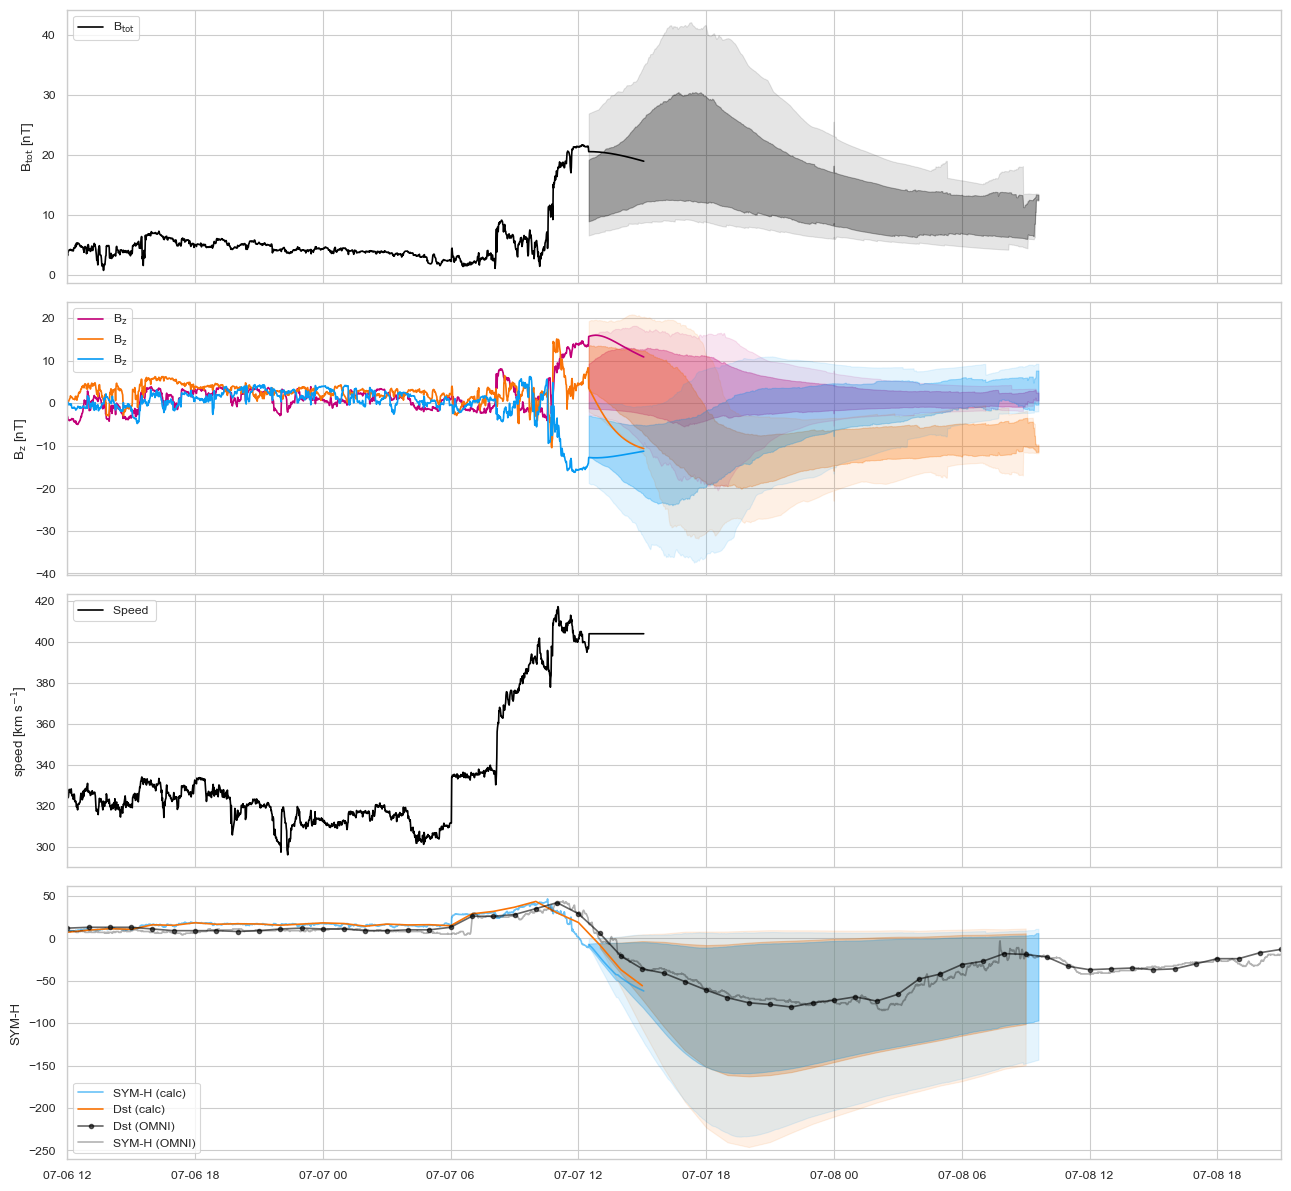

In [60]:
c0 = "xkcd:black"
c1 = "xkcd:magenta"
c2 = "xkcd:orange"
c3 = "xkcd:azure"

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(13,12), sharex=True)

ax1.plot(mdates.num2date(sc_fr['time']), sc_fr['btot'], label=r'B$_{\mathrm{tot}}$', c=c0)
ax1.fill_between(mdates.num2date(sc_err_0_time), y1=sc_err_0_btot, y2=sc_err_1_btot, color=c0, alpha=0.3)
ax1.fill_between(mdates.num2date(sc_err_0_time_2sig), y1=sc_err_0_btot_2sig, y2=sc_err_1_btot_2sig, color=c0, alpha=0.1)
#ax1.errorbar(mdates.num2date(sc_fr['time']), sc_fr['btot'], yerr=sc_fr['btot_err'], c=c0, alpha=.2)
#ax1.plot(mdates.num2date(sc_fr_dst['time']), sc_fr_dst['btot'], label=r'B$_{\mathrm{tot}}$, hourly sampled', c=c0, alpha=0.5)
ax1.set_ylabel(r'B$_{\mathrm{tot}}$ [nT]')
ax1.legend(loc='upper left')

ax2.plot(mdates.num2date(sc_fr['time']), sc_fr['bx'], label=r'B$_{\mathrm{z}}$', c=c1)
ax2.plot(mdates.num2date(sc_fr['time']), sc_fr['by'], label=r'B$_{\mathrm{z}}$', c=c2)
ax2.plot(mdates.num2date(sc_fr['time']), sc_fr['bz'], label=r'B$_{\mathrm{z}}$', c=c3)
ax2.fill_between(mdates.num2date(sc_err_0_time), y1=sc_err_0_bx, y2=sc_err_1_bx, color=c1, alpha=0.3)
ax2.fill_between(mdates.num2date(sc_err_0_time), y1=sc_err_0_by, y2=sc_err_1_by, color=c2, alpha=0.3)
ax2.fill_between(mdates.num2date(sc_err_0_time), y1=sc_err_0_bz, y2=sc_err_1_bz, color=c3, alpha=0.3)
ax2.fill_between(mdates.num2date(sc_err_0_time_2sig), y1=sc_err_0_bx_2sig, y2=sc_err_1_bx_2sig, color=c1, alpha=0.1)
ax2.fill_between(mdates.num2date(sc_err_0_time_2sig), y1=sc_err_0_by_2sig, y2=sc_err_1_by_2sig, color=c2, alpha=0.1)
ax2.fill_between(mdates.num2date(sc_err_0_time_2sig), y1=sc_err_0_bz_2sig, y2=sc_err_1_bz_2sig, color=c3, alpha=0.1)
#ax2.plot(mdates.num2date(sc_fr_dst['time']), sc_fr_dst['bz'], label=r'B$_{\mathrm{z}}, hourly sampled$', c=c3, alpha=0.5)
ax2.set_ylabel(r'B$_{\mathrm{z}}$ [nT]')
ax2.legend(loc='upper left')

ax3.plot(mdates.num2date(sc_fr['time']), sc_fr['speed'], label='Speed ', c=c0)
ax3.set_ylabel('speed [km s$^{-1}$]')
ax3.legend(loc='upper left')

ax4.plot(mdates.num2date(sc_fr['time']), sc_fr['symh'], label='SYM-H (calc)', c=c3, alpha=0.6)
ax4.plot(mdates.num2date(sc_fr_dst['time']), sc_fr_dst['dst'], label='Dst (calc)', c=c2)
ax4.plot(olr['time'], olr['dst'], label='Dst (OMNI)',color='black', marker='o', ms=3, linestyle='-', alpha=0.6)
ax4.plot(ohr['time'], ohr['symh'], label='SYM-H (OMNI)',color='black', linestyle='-', alpha=0.3)
ax4.fill_between(mdates.num2date(sc_dst_err_0_time), y1=sc_dst_err_0_dst, y2=sc_dst_err_1_dst, color=c2, alpha=0.3)
ax4.fill_between(mdates.num2date(sc_err_0_time), y1=sc_err_0_symh, y2=sc_err_1_symh, color=c3, alpha=0.3)
ax4.fill_between(mdates.num2date(sc_dst_err_0_time_2sig), y1=sc_dst_err_0_dst_2sig, y2=sc_dst_err_1_dst_2sig, color=c2, alpha=0.1)
ax4.fill_between(mdates.num2date(sc_err_0_time_2sig), y1=sc_err_0_symh_2sig, y2=sc_err_1_symh_2sig, color=c3, alpha=0.1)
#ax4.fill_between(mdates.num2date(sc_fr_dst['time']), y1=sc_fr_dst['dst_err_min'], y2=sc_fr_dst['dst_err_max'], color=c2, alpha=0.4)
ax4.set_ylabel('SYM-H')
ax4.legend(loc='lower left')
plt.xlim(sc_0_dst['time'][0],olr['time'][-1])
fig.tight_layout()

plt.savefig('Dst_SYMH_3DCORE_July2022_35min_new.pdf')
#plt.close()
plt.show()

In [17]:
#pickle.dump([sc_0['symh'], sc_0['dst_err_min'], sc_0['dst_err_max'], sc_0_dst['dst'], sc_0_dst['dst_err_min'], sc_0_dst['dst_err_max']], open('Dst_SYMH.p', 'wb'))